Analyzing ADWIN Data

In [12]:
import random
from river import drift
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# Load

file = '../fakedata.csv'  # Update later
df = pd.read_csv(file)

# Delete later if not needed
df['Date'] = pd.to_datetime(df['Date'])

time_a_values = df[df["Time Period"] == "Time A"]["Value 1"]
time_b_values = df[df["Time Period"] == "Time B"]["Value 1"]

# Combine for continuous analysis
combined_values = pd.concat([time_a_values, time_b_values]).reset_index(drop=True)
date_average = df.groupby('Date')['Value 1'].mean()


In [47]:
#date_average.values

In [76]:
rng = random.Random()
adwin = drift.ADWIN(delta = .5,
                    clock=1,
                    min_window_length=5,
                    grace_period=2)

#data_stream = rng.choices([0, 1], k=15) + rng.choices(range(4, 8), k=15)
data_stream = [float(value) for value in date_average.values]


In [77]:
for i, val in enumerate(data_stream):
    adwin.update(val)
    if adwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")
        print(adwin.n_detections)
print(adwin.estimation)
print(adwin.variance)

52.475980293
769.6679808495188


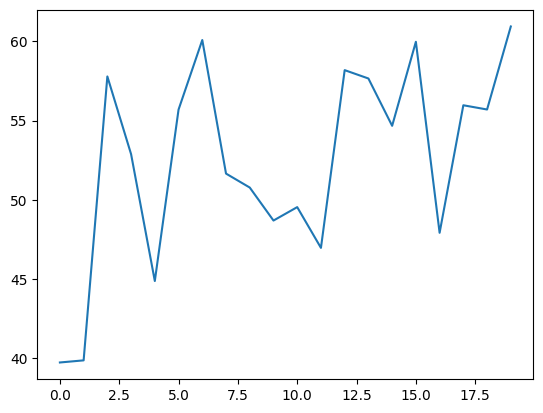

In [78]:
plt.plot(date_average.values)
plt.show()